# PWJ: Linear Elasticity of impact rod

This example code solves a simple linear elasticity problem describing a multi-material cantilever beam. 

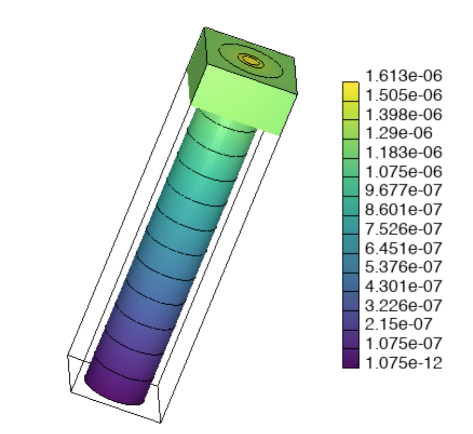

Specifically, we approximate the weak form of

$$−\text{div}(\sigma(u))=0$$

where

$$\sigma(u)=\lambda\cdot\text{div}(u)\cdot I+\mu(\nabla u+\nabla uT)$$

is the stress tensor corresponding to displacement field $u$, and $\lambda$ and $\mu$ are the **material Lame constants**. The boundary conditions are $u=0$ on the fixed part of the boundary with attribute 1, and $\sigma(u)\cdot n=f$ on the remainder with $f$ being a constant pull down vector on boundary elements with attribute 2, and zero otherwise. The geometry of the domain is assumed to be as follows:

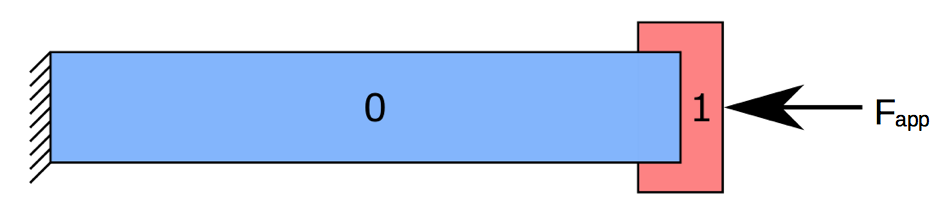

The example demonstrates the use of high-order and NURBS vector finite element spaces with the linear elasticity bilinear form, meshes with curved elements, and the definition of piece-wise constant and vector coefficient objects. Static condensation is also illustrated.

In [ ]:
import numpy as np

# MFEM v4.5 uses deprecated numpy variable numpy.long
major, minor, micro = [int(v) for v in np.__version__.split('.')]
if major == 1 and micro > 23:
    np.long = np.longlong

from glvis import glvis, to_stream
from mfem import path
import mfem.ser as mfem
from mfem.ser import intArray
from pathlib import Path
from unicodedata import lookup

from rich import print

MESH = Path(".").absolute().parent / "gmsh"

print(MESH)

In [ ]:
fname = 'system'

order = 1
# MFEM cannot handle pathlib objects
meshfile = str(MESH / f'{fname}.msh')
print(meshfile)

mesh = mfem.Mesh(meshfile, 1, 1)
mesh.Save("meow.mesh")
dim = mesh.Dimension()
print(f"Dimensions: {dim}")

In [ ]:
# 5. Define a finite element space on the mesh. We use vector FE's, i.e,
#    dim copies of a scalar finite element space. The vector dimension is
#    specified by the last argument of the FiniteElementSpace constructor.
#    For NURBS meshes, we use (degree elevated) NURBS space associted with
#    mesh nodes.
fec = mfem.H1_FECollection(order, dim)
fespace = mfem.FiniteElementSpace(mesh, fec, dim)
print("Number of finite element unknowns: " + str(fespace.GetTrueVSize()))

In [ ]:
# 6. Deterimine list of true (i.e., conforming) essential boundary 
#    degrees of freedom (dof). Here , the boundary conditions (BC) are
#    defined by marking only boundary attribute  1 from the mesh as
#    essential and converting it to a list of true dofs (tdof).
ess_tdof_list = intArray()
ess_bdr = intArray([1]+[0]*(mesh.bdr_attributes.Max()-1))
fespace.GetEssentialTrueDofs(ess_bdr, ess_tdof_list)
print(f"Max Attributes (Domains): {mesh.bdr_attributes.Max()}")

## Applied force

Here we set the applied force $f$ as a MFEM `VectorArrayCoefficient`. We can then create an applied force `pull_force` vector, which contains a list of available boundaries to apply on. We choose a boundary and apply a force value (assuming Neutons). 

Then we can set using `f.Set(...)` which direction this force is applied on the given boundary as a *piecewise* constant coefficient `PWConstCoefficient`. Then generate and assemble the vector $b$.

In this case we apply a force on boundary (attribute 2), top of the sample, in the direction of $\hat{z}$. Note that in the scope of describing surfaces they enumerate from 1..N, but in code it is 0..N-1.

### How much force?

According to uOttawa, cavitation should occur between 2 - 5 kPSI. Therefore assuming we are working in metric units for the whole system, the conversion is:

$$ 1\ \text{PSI} = 6895\ \text{Pa} $$

Therefore the system should have an applied force 
$$F_\text{app} = 13.8\ \text{kPa} \to 34.5\ \text{kPa},$$ 
or, 
$$F_\text{app} = 13,800\ \text{Pa} \to 34,500\ \text{Pa},$$
to be consistent with units of $\lambda$ and $\mu$.

### Actual measurement

We find that the force applied at the surface does max out at 4.5 kPSI when a $P_{pump}$ = 9 kPSI with the **pulse on**, where it is 2 kPSI with the **pulse off**.

| P$_{pump}$ (kPSI) | Pulse | P$_{App}$ (kPSI) | $P_{App}$ (MPa) |
| :-: | :-: | :-: | :-: |
| 9 | off | 2.0 | 13.79 |
| 9 | on | 4.5 | 31.03 |
| 6 | off | | |
| 6 | on | | |
| 3 | off | | |
| 3 | on | | |

**PS** The current diameter of the pulsed water jet is assumed to be 4.7 mm. Possibly convert that to N to apply. This should be a DataFrame for visualization.

In [ ]:
# 7. Set up the linear form b(.) which corresponds to the RHS of 
#    the FEM linear system. In this case, b_i equals the boundary 
#    integral of f*phi_i where f represents a "pull down" force on 
#    the Neumann part of the boundary and phi_i are are the basis 
#    functions in the finite element fespace. The force is defined 
#    by the VectorArrayCoefficient object f, which is a vector of 
#    Coefficient objects. The fact that f is non-zero on boundary
#    attribute 2 is indicated by the use of the piece-wise contstants
#    coefficient for its last component.
pwj_force = 23957 # Pa

f = mfem.VectorArrayCoefficient(dim)
for i in range(dim-1):
    f.Set(i, mfem.ConstantCoefficient(0.0))

pull_force = mfem.Vector([0] * mesh.bdr_attributes.Max())
pull_force[1] = pwj_force
f.Set(dim-1, mfem.PWConstCoefficient(pull_force))

b = mfem.LinearForm(fespace)
b.AddBoundaryIntegrator(mfem.VectorBoundaryLFIntegrator(f))
print(f"RHS: b_i = "
      + f"{lookup('INTEGRAL')} "
      + "f"
      + f"{lookup('DOT OPERATOR')}"
      + f"{lookup('GREEK SMALL LETTER PHI')}_i")
b.Assemble()

In [ ]:
# 8. Define the solution vector x as a finite element grid
#    function corresponding to fespace. Initialize x with intial
#    guess of zero, which satisfies the BC
x = mfem.GridFunction(fespace)
x.Assign(0.0)

## Conversion to Lame Coefficients

Since MFEM uses Lame coefficients $\lambda$ and $\mu$, we must convert to them from either Young's Modules $E$, Shear Modulus $G$, and/or Poisson's ratio $\nu$. The equations are as follows,

$$ \lambda = \frac{E\nu}{(1+\nu)(1-2\nu)} = \frac{G(E-2G)}{3G-E}$$

$$ \mu = G $$

Bear in mind, **you may get the wildly different values if you use datasheets**. This is because some don't report error bars or ranges of the available values. I am currently using the following material properties: [Ti6Al4V Grade5](https://www.azom.com/properties.aspx?ArticleID=1547) and [Al 6061-T6](https://www.thomasnet.com/articles/metals-metal-products/6061-aluminum/). Note I am using the tempered version of Al 6061, because I cannot remember which specific alloy it was at the moment.

| Ti6Al4V Grade 5 | Variable | Value | Unit |
| :- | :-: | :-: | :-: |
| Young's Modulus | $E$ | 114.5 | GPa |
| Shear Modulus | $G$ | 43 | GPa |
| Poisson's ratio | $\nu$ | 0.33 | |

| Al 6061-T6 | Variable | Value | Unit |
| :- | :-: | :-: | :-: |
| Young's Modulus | $E$ | 68.9 | GPa |
| Shear Modulus | $G$ | 26 | GPa |
| Poisson's ratio | $\nu$ | 0.325* | |

$$ G = \frac{E}{2(1+\nu)} $$

$$ \nu_\text{Al} \approx 0.325$$

| Attribute | Material | $\lambda$ (GPa) | $\mu$ |
| :-: | :- | :-: | :-: |
| 0 | Al 6061 | 48 | 26 |
| 1 | Ti6Al4V | 83 | 43 |

**NB** $\lambda_0 = \lambda_\text{Al}$ and $\lambda_1 = \lambda_\text{Ti6Al4V}$

See below in code for calulations.

In [ ]:
def lambda_shear(E, G):
    return G*(E-2*G)/(3*G-E)

def lambda_poisson(E, nu):
    return E*nu/((1 + nu)(1 - 2*nu))

young_mod = {}
young_mod['Ti6Al4V-G5']    = 114.5E9  # GPa
young_mod['Al 6061-T6'] = 68.9E9 # GPa

shear_mod = {}
shear_mod['Ti6Al4V-G5']    = 43E9 # GPa
shear_mod['Al 6061-T6'] = 26E9 # GPa

lamb_0 = lambda_shear(young_mod['Al 6061-T6'], shear_mod['Al 6061-T6'])
lamb_1 = lambda_shear(young_mod['Ti6Al4V-G5'], shear_mod['Ti6Al4V-G5'])

mu_0 = shear_mod['Al 6061-T6']
mu_1 = shear_mod['Ti6Al4V-G5']

print(f"Al 6061-T6  | {lookup('GREEK SMALL LETTER LAMDA')}_0 : {lamb_0:0.3g} | {lookup('GREEK SMALL LETTER MU')}_0 : {mu_0:0.3g}")
print(f"Ti6Al4V-G5  | {lookup('GREEK SMALL LETTER LAMDA')}_1 : {lamb_1:0.3g} | {lookup('GREEK SMALL LETTER MU')}_1 : {mu_1:0.3g}")

In [ ]:
# 9. Set up the bilinear form of a(., .) on the finite element
#    space corresponding to the linear elasticity integrator with
#    piece-wise constants coefficient lambda (lamb) and mu.
print(mesh.attributes.Max())
lamb = mfem.Vector(mesh.attributes.Max())
lamb.Assign(1.0)
lamb[0] *= lamb_0
lamb[1] *= lamb_1
lamb_func = mfem.PWConstCoefficient(lamb)

mu = mfem.Vector(mesh.attributes.Max())
mu.Assign(1.0)
mu[0] *= mu_0
mu[1] *= mu_1
mu_func = mfem.PWConstCoefficient(mu)

a = mfem.BilinearForm(fespace)
a.AddDomainIntegrator(mfem.ElasticityIntegrator(lamb_func, mu_func))

In [ ]:
# 10. Assemble the bilinear form and corresponding linear system,
#     applying any necessary transformations such as: eliminating 
#     boundary conditions, applying conforming constraints for 
#     non-conforming AMR, static Condensation, etc.
print(f"LHS: A_ij = "
      + f"{lookup('INTEGRAL')} "
      + f"{lookup('NABLA')}({lookup('GREEK SMALL LETTER PHI')}_i)"
      + f"{lookup('DOT OPERATOR')}"
      + f"{lookup('NABLA')}({lookup('GREEK SMALL LETTER PHI')}_j)")
static_cond = False
if (static_cond):
    a.EnableStaticCondensation()
a.Assemble()

A = mfem.OperatorPtr()
B = mfem.Vector()
X = mfem.Vector()
a.FormLinearSystem(ess_tdof_list, x, b, A, X, B)
print('Size of linear system: ' + str(A.Height()))

In [ ]:
# 11. Solve
AA = mfem.OperatorHandle2SparseMatrix(A)
M = mfem.GSSmoother(AA)
mfem.PCG(AA, M, B, X, 1, 500, 1e-8, 0.0)

In [ ]:
# 12. Recover the solution as a finite element grid function
A.RecoverFEMSolution(X, b, x)

In [ ]:
# 13. For non-NURBS meshs, make the mesh curved based on the
#     finite element space. Meaning, we define the mesh elements
#     through a fespace based transormation of the reference element.
#     This allows us to save the displaced mesh as a curved mesh 
#     when using high-order finte element displacement field. We
#     assume that the initial mesh (read from file) is not higher 
#     order curved mesh compared to the chosen FE space.
if not mesh.NURBSext:
    mesh.SetNodalFESpace(fespace)

In [ ]:
# 14. Save the displacement mesh and the inverted solution (which
#     gives the backwards displacements to the original grid). 
#     this output can be view later using GLVis 
#     "glvis -m displaced.mesh -g sol.gf"
nodes = mesh.GetNodes()
nodes += x
x *= -1

mesh.Print(f'{fname}.mesh', 8)
x.Save(f'{fname}.gf', 8)
#mesh.Save(f'{fname}.mesh')

In [ ]:
visualize = True
if visualize:
    sol_sock = mfem.socketstream("localhost", 19916)
    sol_sock.precision(8)
    sol_sock.send_solution(mesh, x)